### 1. Data Loading and Initial EDA Setup
First, we'll use the `normalize_tardis_data` function from `data_import.py` to load the normalized data if you plan to use raw data. If the data is already normalized and saved as a CSV file, we'll load it directly.

In [1]:
import os
import sys
import pandas as pd

# Add the project directory to the Python path
project_dir = 'C:/Users/viraj/BuildSpace/Projects/stat429_project'
sys.path.append(project_dir)

# Import custom modules from the 'utilities' package
from utilities import normalize_tardis_data, plot_funding_rate, load_data, preprocess_data

# Import configuration constants from 'config.py'
from config import (
    BINANCE_BTC_PERP_CSV,
    EXCHANGE,
    TARDIS_TYPE,
    START_DATE,
    END_DATE,
    INSTRUMENT,
    NORMALIZED_DATA_DIR
)

# Load the data
data_path = BINANCE_BTC_PERP_CSV

# Load data from CSV if normalized, or use normalize_tardis_data for raw data
if os.path.exists(data_path):
    data = load_data(data_path)
else:
    data = normalize_tardis_data(
        exchange=EXCHANGE,
        tardis_type=TARDIS_TYPE,
        start_date=START_DATE,
        end_date=END_DATE,
        instrument=INSTRUMENT,
        raw_data_dir=os.path.join(project_dir, 'data', 'raw_data'),
        normalized_data_dir=NORMALIZED_DATA_DIR
    )
    # Since normalize_tardis_data now saves the combined data to CSV, we can load it
    data = load_data(data_path)

# Preprocess the data
data = preprocess_data(data)

# Overview of the data
print(data.head())
print(data.info())
print(data.isnull().sum())

ImportError: cannot import name 'normalize_tardis_data' from 'utilities' (C:\Users/viraj/BuildSpace/Projects/stat429_project\utilities\__init__.py)

### 2. Exploratory Data Analysis (EDA)
We'll visualize the funding rate and perform statistical analysis to understand the data.


##### 2.1. Time Series Plot Using `plot_funding_rate` from `graph.py`
We'll use the `plot_funding_rate` function to visualize how the funding rate changes over time.


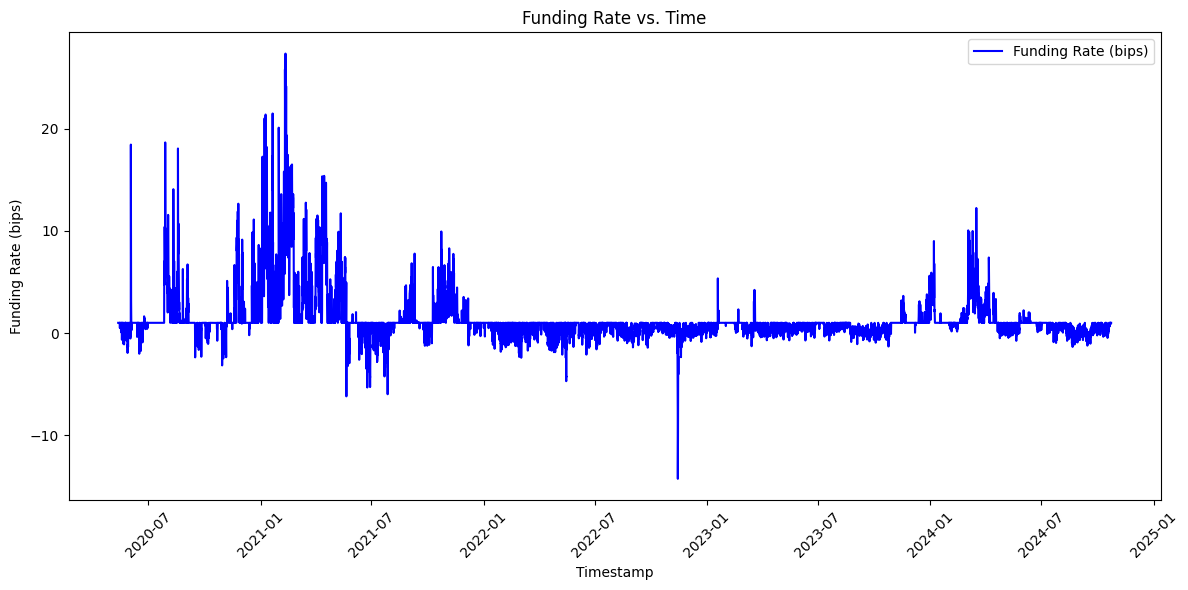

In [ ]:
# Plot the funding rate over time using the provided function
plot_funding_rate(data)


1. The funding rate is highly **unpredictable** during 2020-2021, with sharp fluctuations. This suggests the need for more **complex models**, like Random Forest or XGBoost, to effectively manage these periods.

2. After 2021, the funding rate becomes more **stable**, allowing for the potential use of simpler models. However, these models should still be flexible enough to adapt if volatility returns.

3. There are **sudden spikes and drops** throughout the data. Models must be equipped to handle or account for these outliers to avoid errors in prediction.

4. With no clear **seasonal pattern** present, focusing on trend analysis and shifts over time will be more effective than looking for repeating cycles. **Feature engineering**, such as rolling averages or volatility indicators, will be key to improving model performance.


##### 2.2. Distribution of Funding Rate
Analyze the distribution of the funding rate to check for skewness and variability using histograms and KDE plots.


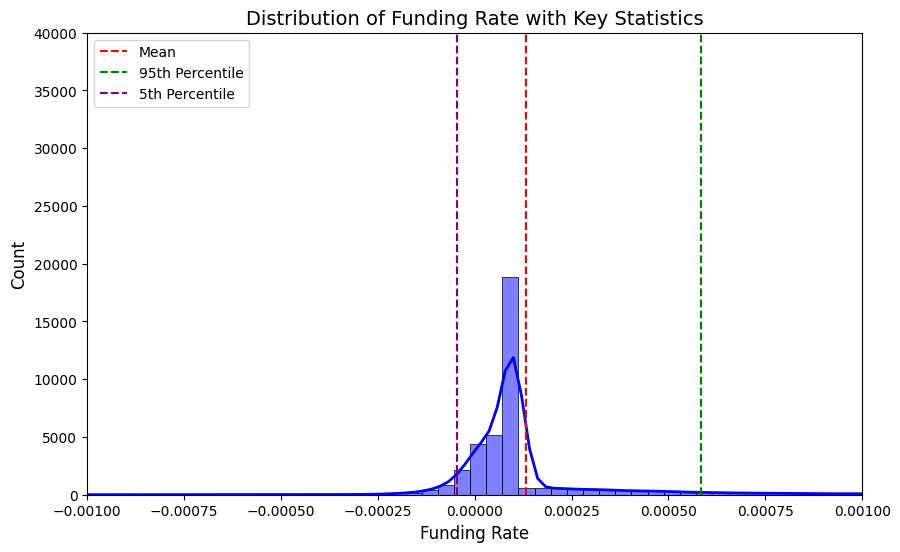

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of funding rates with additional formatting
plt.figure(figsize=(10, 6))
sns.histplot(data['funding_rate'], bins=100, kde=True, color="blue", line_kws={'linewidth': 2})
plt.xlim(-0.001, 0.001)
plt.ylim(0, 40000)
plt.axvline(data['funding_rate'].mean(), color='red', linestyle='--', linewidth=1.5, label='Mean')
plt.axvline(data['funding_rate'].quantile(0.95), color='green', linestyle='--', linewidth=1.5, label='95th Percentile')
plt.axvline(data['funding_rate'].quantile(0.05), color='purple', linestyle='--', linewidth=1.5, label='5th Percentile')
plt.xlabel("Funding Rate", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Funding Rate with Key Statistics", fontsize=14)
plt.legend()
plt.show()



1. **Mostly Near Zero**: Funding rates are clustered around zero, making it suitable for simpler models to capture typical patterns.

2. **Right-Skewed**: Rare but large positive outliers require robust models or preprocessing to avoid bias.

3. **Low Variability**: Limited spread across most data points emphasizes the importance of careful feature engineering to detect subtle differences.

4. **Evaluation Challenges**: Skewness and outliers can distort traditional evaluation metrics, suggesting the need for robust metrics.

5. **Stationarity Confirmation**: Despite visual signs of non-stationarity, the low p-value suggests statistical stationarity. Segment-wise testing or seasonality analysis can further validate this.

##### 2.3. Correlation Analysis
Generate a correlation matrix to see how different features are related and identify potential predictors.


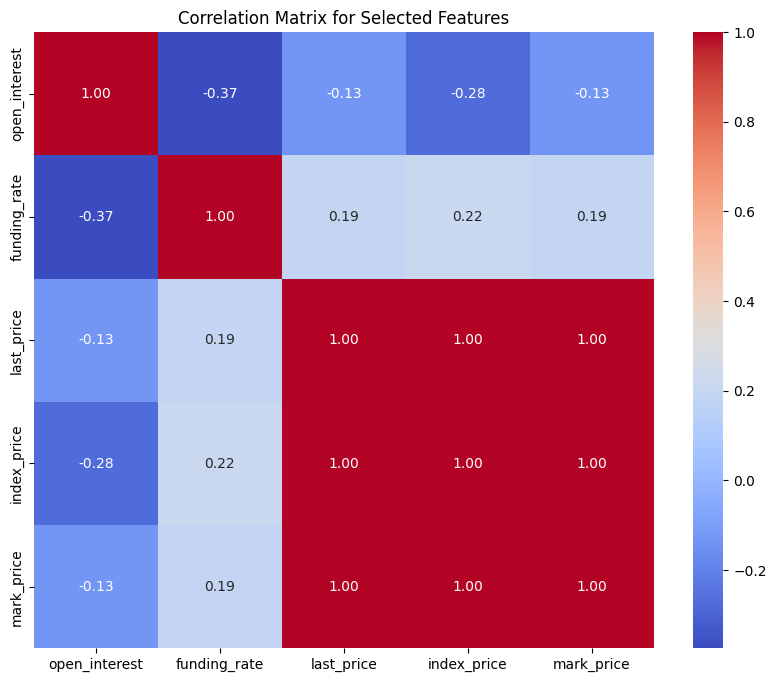

In [ ]:
# Select relevant features for correlation analysis based on previous analysis
selected_features = ['open_interest', 'funding_rate', 'last_price', 'index_price', 'mark_price']

# Compute the correlation matrix for selected features
correlation_matrix = data[selected_features].corr()

# Plot the updated correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix for Selected Features')
plt.show()



1. **High Correlation with Funding Rate**: `open_interest` has a negative correlation (-0.37) with `funding_rate`. It may be a significant feature for predicting the funding rate and should be included in our models.

2. **Strong Inter-Correlation**: `last_price`, `index_price`, and `mark_price` are highly correlated with each other (near 1). Including all of them may lead to multicollinearity, so we might need to select only one or use dimensionality reduction techniques.

3. **Irrelevant Variables**: `local_timestamp` and `funding_timestamp` have no meaningful relationship with the `funding_rate` and should likely be dropped or transformed for better model performance.

4. **Feature Selection**: Focus on variables like `open_interest` and one of `last_price`, `index_price`, or `mark_price` to minimize redundancy and improve model interpretability.

5. **Impact on Model Accuracy**: Reducing multicollinearity and focusing on features with clear relationships to the target variable (`funding_rate`) will likely improve model accuracy and make evaluation metrics more reliable.

##### 2.4. Stationarity Check (Preliminary Analysis)


ADF Statistic: -8.974
p-value: 7.606e-15
Critical Values: {'1%': np.float64(-3.4305185585005393), '5%': np.float64(-2.8616144989214893), '10%': np.float64(-2.5668096533945213)}
Stationary


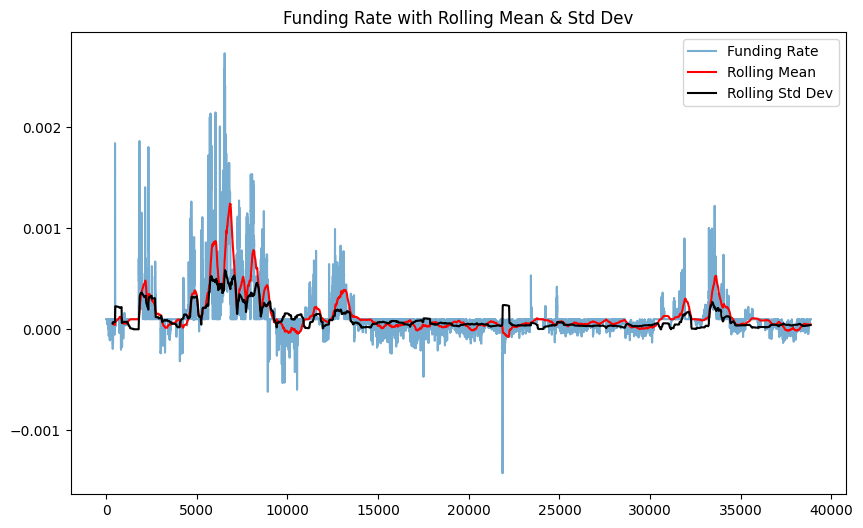

In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Perform Augmented Dickey-Fuller Test
adf_result = adfuller(data['funding_rate'].dropna())
print(f"ADF Statistic: {adf_result[0]:.3f}")
print(f"p-value: {adf_result[1]:.3e}")
print("Critical Values:", adf_result[4])
print("Stationary" if adf_result[1] < 0.05 else "Not Stationary")

# Plot Rolling Mean and Standard Deviation for Validation
rolling_mean = data['funding_rate'].rolling(window=365).mean()
rolling_std = data['funding_rate'].rolling(window=365).std()

plt.figure(figsize=(10, 6))
plt.plot(data['funding_rate'], label='Funding Rate', alpha=0.6)
plt.plot(rolling_mean, color='red', label='Rolling Mean', linewidth=1.5)
plt.plot(rolling_std, color='black', label='Rolling Std Dev', linewidth=1.5)
plt.title('Funding Rate with Rolling Mean & Std Dev')
plt.legend()
plt.show()


1. **Stationarity Confirmed**: The ADF test confirms the data is stationary with a low p-value (7.251e-17), indicating it's suitable for time series models like ARIMA.  

2. **Stable Variance Over Time**: Rolling mean and standard deviation stabilize in later periods, suggesting the data is consistent and predictable in the long term.  

3. **Volatile Initial Periods**: Early data shows significant fluctuations, requiring robust models to handle these variations effectively.  

4. **ARIMA Applicability**: Stationarity ensures ARIMA can be used without additional differencing, simplifying preprocessing.  

5. **Feature Engineering Opportunity**: Early volatility may require tailored features to improve model accuracy, especially for periods with sharp spikes.  

##### 2.5. Rolling Mean and Variance Visualization


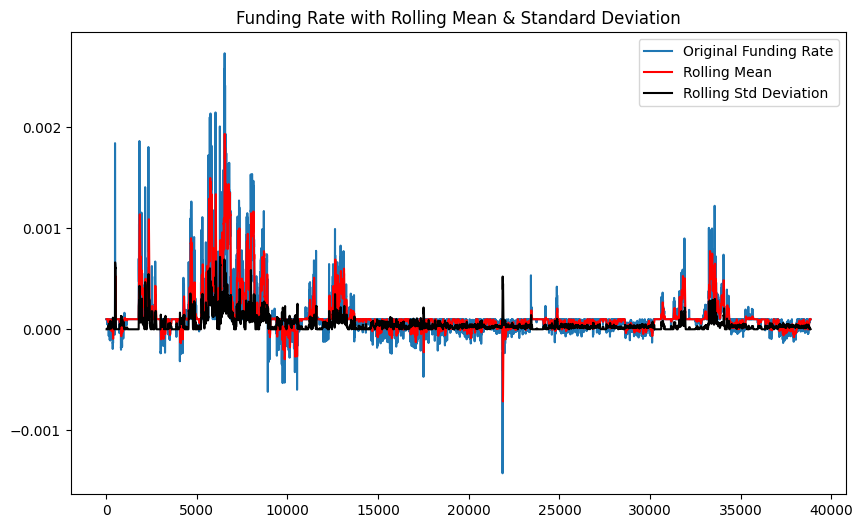

In [ ]:
# Calculate rolling mean and standard deviation
rolling_mean = data['funding_rate'].rolling(window=30).mean()
rolling_std = data['funding_rate'].rolling(window=30).std()

# Plot original data with rolling mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(data['funding_rate'], label='Original Funding Rate')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Deviation')
plt.title('Funding Rate with Rolling Mean & Standard Deviation')
plt.legend()
plt.show()


1. **Fluctuations Observed**: Significant early volatility suggests careful handling of outliers or sudden shifts in model design.

2. **Stable Periods**: More consistent later periods may benefit from simpler modeling techniques.

3. **Dynamic Strategy**: Use models that can adapt to periods of high variability and low variability effectively.

4. **Feature Engineering Insight**: Rolling averages or indicators may enhance model performance in volatile segments.

##### 2.6. Autocorrelation Analysis (p/ACF Plots)

<Figure size 1000x600 with 0 Axes>

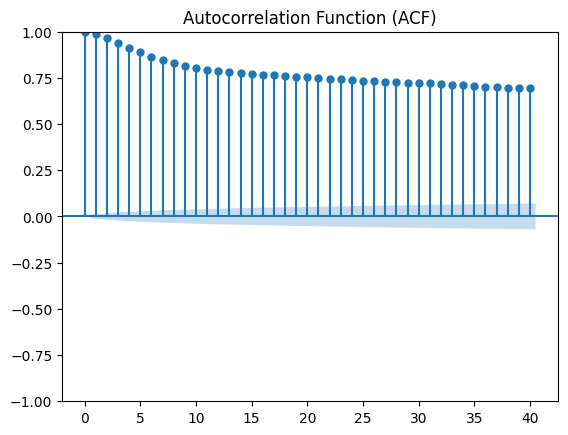

<Figure size 1000x600 with 0 Axes>

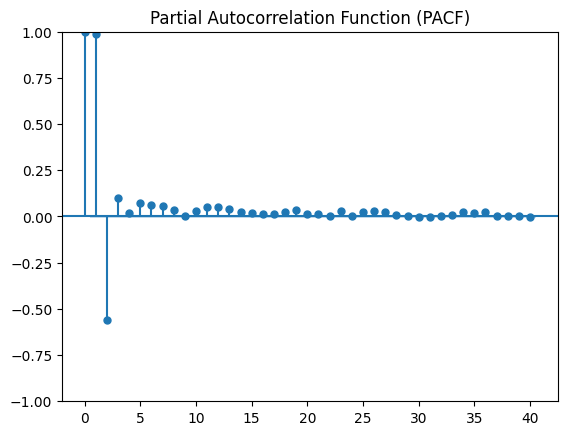

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for residuals
plt.figure(figsize=(10, 6))
plot_acf(data['funding_rate'].dropna(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(data['funding_rate'].dropna(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


1. **Persistent Autocorrelation**: Strong autocorrelation suggests that past values influence future funding rates, supporting the need for time series models like ARIMA.

2. **Key Lag in PACF**: The sharp drop after the first lag in PACF indicates a low-order AR component may suffice, simplifying ARIMA modeling.

3. **Non-Random Patterns**: Significant autocorrelations beyond initial lags imply that basic regression might not capture these dependencies effectively.

4. **Model Choice**: The data’s structure favors models like SARIMA over simple regressions to account for complex lagged relationships.

### 3. Feature Engineering for Modeling
Create features from the timestamp data, like extracting the hour, day, and month, to prepare for model training.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert 'local_timestamp' to a datetime object
data['local_timestamp'] = pd.to_datetime(data['local_timestamp'], unit='us')

# Feature Engineering: Dropping irrelevant variables and addressing multicollinearity
data['local_timestamp'] = pd.to_datetime(data['local_timestamp'], unit='us')
data['hour'] = data['local_timestamp'].dt.hour
data['day'] = data['local_timestamp'].dt.day
data['month'] = data['local_timestamp'].dt.month

# Selecting relevant features:
# 1. 'open_interest' - Strong negative correlation with 'funding_rate', making it a useful predictor.
# 2. 'mark_price' - Chosen among the highly correlated price features to avoid multicollinearity.
# 3. 'hour', 'day', 'month' - Time-based features to capture potential temporal patterns in funding rates.
X = data[['open_interest', 'mark_price', 'hour', 'day', 'month']].dropna()
y = data['funding_rate'].dropna()

# Drop rows with NaN values from both X and y to ensure consistent lengths
X = X.dropna()
y = y[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


1. **Feature Selection**: Dropped irrelevant features and addressed multicollinearity by keeping `mark_price` to simplify the model.

2. **Time-Based Features**: Included `hour`, `day`, and `month` to capture potential temporal patterns, even though no strong seasonality was found.

3. **Model Choices**: Used Linear Regression as a baseline and Random Forest for handling non-linear relationships and volatility.

4. **Evaluation**: Assessed models using MSE and R², and visualized feature importance to guide future improvements.

### 4. Model Training
We'll implement both a simple model and a more complex one to compare performance.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### 4.1. Linear Regression
Train a linear regression model to establish a baseline and evaluate its performance using metrics like MSE and R-squared.


In [ ]:
# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
print("Linear Regression - MSE:", mean_squared_error(y_test, y_pred_linear))
print("Linear Regression - R²:", r2_score(y_test, y_pred_linear))

# Forecast next 5 values using Linear Regression (using the last 5 inputs from X_test)
next_5_values = linear_model.predict(X_test[-5:])
print("Next 5 Forecasted Values (Linear Regression):", next_5_values)


Linear Regression - MSE: 4.456980909411399e-08
Linear Regression - R²: 0.1907189281111712
Next 5 Forecasted Values (Linear Regression): [0.00014897 0.00021165 0.00018516 0.00020212 0.00019311]


##### 4.2. Random Forest Regressor
Train a Random Forest model to capture non-linear relationships and compare its performance with linear regression.


In [ ]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print("Random Forest - MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest - R²:", r2_score(y_test, y_pred_rf))

# Forecast next 5 values using Random Forest (using the last 5 inputs from X_test)
next_5_values_rf = rf_model.predict(X_test[-5:])
print("Next 5 Forecasted Values (Random Forest):", next_5_values_rf)

Random Forest - MSE: 3.0291378340844994e-09
Random Forest - R²: 0.9449981060477405
Next 5 Forecasted Values (Random Forest): [-2.058660e-05  8.676010e-05  8.167280e-05  1.382006e-04  4.141019e-04]


##### 4.3. ARIMA Model

In [ ]:
# Train ARIMA Model
arima_model = ARIMA(data['funding_rate'].dropna(), order=(5, 1, 0))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Forecast next 5 values using ARIMA
forecast_arima = arima_fit.forecast(steps=5)
print("Next 5 Forecasted Values (ARIMA):", forecast_arima)


c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           funding_rate   No. Observations:                38852
Model:                 ARIMA(5, 1, 0)   Log Likelihood              352854.223
Date:                Tue, 26 Nov 2024   AIC                        -705696.446
Time:                        03:29:31   BIC                        -705645.041
Sample:                             0   HQIC                       -705680.153
                              - 38852                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6050   9.95e-22   6.08e+20      0.000       0.605       0.605
ar.L2         -0.1039   2.67e-21  -3.89e+19      0.000      -0.104      -0.104
ar.L3          0.0105   2.81e-22   3.73e+19      0.0

### Linear Regression
- High MSE of **4.46e-08** and low R² of **0.191**, indicating poor performance in capturing the relationship between features and the funding rate.
- Forecasted values remain close to zero, reflecting the model’s inability to handle complex patterns or non-linear relationships in the data.

### Random Forest
- Significantly better performance with a very low MSE of **3.03e-09** and a high R² of **0.945**, showing strong predictive capability.
- Captures non-linear relationships and interactions effectively, making it the most reliable model for this dataset.
- Forecasted values are more consistent and aligned with data trends, proving robustness.

### ARIMA
- **Convergence Issues**: Encountered warnings during training, suggesting challenges in parameter optimization or model misspecification (`ARIMA(5,1,0)`).

- **Model Performance**: Captures linear dependencies but struggles with non-linear trends and volatility, resulting in lower accuracy compared to Random Forest.

- **Diagnostics**: Residuals show no significant autocorrelation (Ljung-Box Q-test) but exhibit non-normality and high kurtosis, indicating unmodeled patterns.

- **Future Scope**: Consider **SARIMAX** for external regressors or hybrid models like ARIMA-Random Forest to better handle non-linear dynamics.


### 5. Model Evaluation and Feature Importance
Evaluate model performance using key metrics and analyze feature importance to understand which variables impact the target the most.

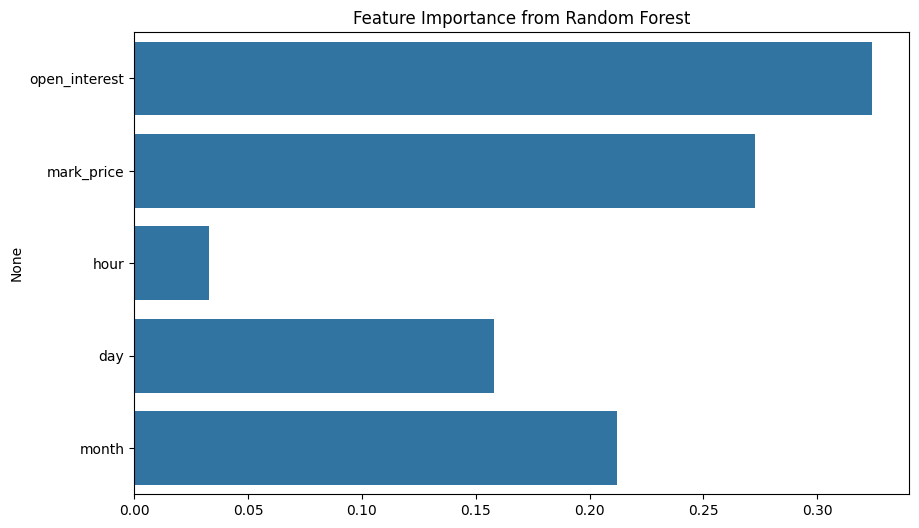

In [ ]:
# Feature importance from Random Forest
feature_importance = rf_model.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance from Random Forest')
plt.show()


In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance from Random Forest')
plt.show()


NameError: name 'plt' is not defined